# Tutorial - Wave Propagation (Angular Spectrum Method)

This tutorial demonstrates a first implementation of wave propagation in Optiland using the **Angular Spectrum Method (ASM)**.

In this notebook we will:
- Build a simple lens system
- Configure fields and wavelengths
- Compute a propagated complex field at multiple `z` planes
- Visualize normalized intensity along propagation

> Note: this notebook is intended as a development tutorial. The API and output tensor layout may change.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from optiland.optic import Optic
from optiland.physical_apertures import PolygonAperture
from optiland.solves import QuickFocusSolve
import optiland.backend as be

## 1. Backend selection

Optiland supports multiple backends. Here we use **PyTorch** to exercise GPU and complex FFT paths.

In [2]:
be.set_backend("torch")

## 2. Build an example lens

We build a multi-surface lens and define:
- An entrance pupil (EPD)
- Two fields (angles)
- Two wavelengths (one primary)

Then we run a quick focus solve and visualize the layout.

╒════╤═════════════════╤═══════════╤═══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type            │ Comment   │    Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═════════════════╪═══════════╪═══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar          │           │  inf      │   inf       │ Air        │       0 │         2.30501 │
│  1 │ Standard        │           │   22.0136 │     3.25896 │ SK16       │       0 │         2.30501 │
│  2 │ Standard        │           │ -435.76   │     6.00755 │ Air        │       0 │         2.03363 │
│  3 │ Standard        │           │  -22.2133 │     0.99997 │ F2         │       0 │         1.20443 │
│  4 │ Stop - Standard │           │   20.2919 │     4.75041 │ Air        │       0 │         1.14025 │
│  5 │ Standard        │           │   79.6836 │     2.95208 │ SK16       │       0 │         1.68566 │
│  6 │ Standard        │           │  -18.3953 │    42.3963  │ A

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='X [mm]', ylabel='Y [mm]'>)

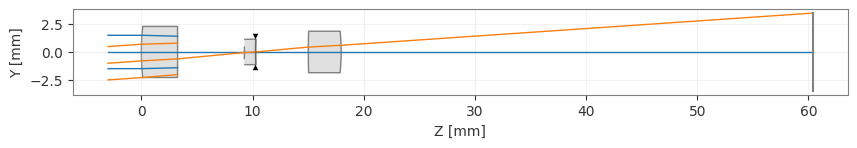

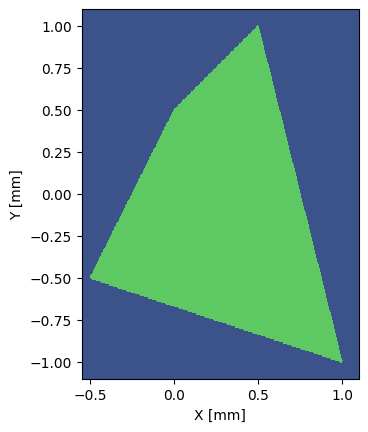

In [3]:
lens = Optic()

ap = PolygonAperture(x=[-0.5, 0, 0.5, 1], y=[-0.5, 0.5, 1, -1])

lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=1, radius=22.01359, thickness=3.25896, material="SK16")
lens.add_surface(index=2, radius=-435.76044, thickness=6.00755)
lens.add_surface(index=3, radius=-22.21328, thickness=0.99997, material=("F2", "schott"), aperture=ap)
lens.add_surface(index=4, radius=20.29192, thickness=4.75041, is_stop=True)
lens.add_surface(index=5, radius=79.68360, thickness=2.95208, material="SK16")
lens.add_surface(index=6, radius=-18.39533, thickness=42.20778)
lens.add_surface(index=7)

lens.set_aperture(aperture_type="EPD", value=3)

lens.set_field_type(field_type="angle")
lens.add_field(y=0)
lens.add_field(y=4)

lens.add_wavelength(value=0.48)
lens.add_wavelength(value=0.55, is_primary=True)

lens.update_paraxial()

solver = QuickFocusSolve(lens)
solver.apply()

lens.info()
lens.draw()
ap.view()

## 3. Compute the propagated field

We compute the complex field at multiple planes `z`.

Output convention used in this development notebook:
- If the propagator returns `(W, N, N)`, we treat it as a single field and store as `(F=1, W, N, N)`.
- If the propagator returns `(F, W, N, N)`, we store it directly.

The final stacked output is shaped as:
- `field_stack`: `(S, F, W, N, N)` where `S = num_slices`.

In [4]:
def _is_torch(x):
    return x.__class__.__module__.startswith("torch")


def _to_numpy(x):
    if _is_torch(x):
        x = x.detach()
        if getattr(x, "is_cuda", False):
            x = x.cpu()
        x = x.numpy()
    return np.asarray(x)


def compute_field_stack(
    lens,
    distance,
    wave_resolution,
    pitch,
    field=(0.0, 0.0),
    wavelengths="all",
    num_slices=50,
    beam_waist="auto",
):
    import time
    import numpy as np

    z = np.linspace(0.0, float(distance) * 1.1, num_slices)

    t0 = time.perf_counter()
    U0 = lens.wave_propagator.compute_field(
        z_target=float(z[0]),
        num_points=wave_resolution,
        dx=pitch,
        field=field,
        wavelengths=wavelengths,
        beam_waist=beam_waist,
    )
    dt = time.perf_counter() - t0
    print(f"slice 1/{num_slices} | z={z[0]:.6g} | compute_field: {dt:.4f}s")

    nd = getattr(U0, "ndim", None)
    is_torch = U0.__class__.__module__.startswith("torch")

    if nd == 3:
        F, W, N = 1, int(U0.shape[0]), int(U0.shape[1])
    elif nd == 4:
        F, W, N = int(U0.shape[0]), int(U0.shape[1]), int(U0.shape[2])
    else:
        raise ValueError(f"Expected (W,N,N) or (F,W,N,N), got {getattr(U0,'shape',None)}")

    if is_torch:
        import torch

        stack = torch.empty((num_slices, F, W, N, N), dtype=U0.dtype, device=U0.device)
        if nd == 3:
            stack[0, 0].copy_(U0)
        else:
            stack[0].copy_(U0)

        for i in range(1, num_slices):
            zi = float(z[i])
            t0 = time.perf_counter()
            U = lens.wave_propagator.compute_field(
                z_target=zi,
                num_points=wave_resolution,
                dx=pitch,
                field=field,
                wavelengths=wavelengths,
                beam_waist=beam_waist,
            )
            dt = time.perf_counter() - t0
            print(f"slice {i+1}/{num_slices} | z={zi:.6g} | compute_field: {dt:.4f}s")

            if nd == 3:
                stack[i, 0].copy_(U)
            else:
                stack[i].copy_(U)

        return {"z": z, "field": stack}

    stack = np.empty((num_slices, F, W, N, N), dtype=U0.dtype)
    stack[0, 0] = U0 if nd == 3 else stack.__setitem__((0,), U0)

    if nd == 3:
        stack[0, 0] = U0
    else:
        stack[0] = U0

    for i in range(1, num_slices):
        zi = float(z[i])
        t0 = time.perf_counter()
        U = lens.wave_propagator.compute_field(
            z_target=zi,
            num_points=wave_resolution,
            dx=pitch,
            field=field,
            wavelengths=wavelengths,
            beam_waist=beam_waist,
        )
        dt = time.perf_counter() - t0
        print(f"slice {i+1}/{num_slices} | z={zi:.6g} | compute_field: {dt:.4f}s")

        if nd == 3:
            stack[i, 0] = U
        else:
            stack[i] = U

    return {"z": z, "field": stack}

In [5]:
pitch = 5e-3
wave_resolution = int(lens.aperture.value / pitch)
print("wave_resolution:", wave_resolution)

stack = compute_field_stack(
    lens=lens,
    distance=100,
    wave_resolution=wave_resolution,
    pitch=pitch,
    field=[(0, 0), (0.1, 0.2)],
    wavelengths="all",
    num_slices=30,
    beam_waist="auto",
)

wave_resolution: 600
slice 1/30 | z=0 | compute_field: 0.0319s
slice 2/30 | z=3.7931 | compute_field: 0.3158s
slice 3/30 | z=7.58621 | compute_field: 0.3276s
slice 4/30 | z=11.3793 | compute_field: 0.6429s
slice 5/30 | z=15.1724 | compute_field: 0.7725s
slice 6/30 | z=18.9655 | compute_field: 0.9692s
slice 7/30 | z=22.7586 | compute_field: 0.9294s
slice 8/30 | z=26.5517 | compute_field: 0.9284s
slice 9/30 | z=30.3448 | compute_field: 0.9453s
slice 10/30 | z=34.1379 | compute_field: 0.9404s
slice 11/30 | z=37.931 | compute_field: 0.9349s
slice 12/30 | z=41.7241 | compute_field: 0.9331s
slice 13/30 | z=45.5172 | compute_field: 0.9466s
slice 14/30 | z=49.3103 | compute_field: 0.9376s
slice 15/30 | z=53.1034 | compute_field: 0.9239s
slice 16/30 | z=56.8966 | compute_field: 0.9456s
slice 17/30 | z=60.6897 | compute_field: 1.1196s
slice 18/30 | z=64.4828 | compute_field: 1.1215s
slice 19/30 | z=68.2759 | compute_field: 1.1048s
slice 20/30 | z=72.069 | compute_field: 1.1066s
slice 21/30 | z=7

## 4. Visualizing Intensity Along Propagation

The propagated complex field can be inspected as normalized intensity at different axial positions `z`.

The interactive viewer allows you to:

- Scroll through propagation slices.
- Select field index and wavelength.
- Control zoom around the optical axis.
- Choose the normalization strategy.

Normalization modes:

- `norm="global"` uses a single maximum over all slices for the selected field and wavelength. This preserves relative power variations along propagation.
- `norm="per_frame"` normalizes each slice independently. This enhances local structure but removes axial power comparison.

The display is cropped around the center of the grid to emphasize the main lobe and focal evolution.

In [6]:
def visualize_field_stack(stack, pitch, cmap="inferno"):
    z = stack["z"]
    U = stack["field"]

    is_torch = U.__class__.__module__.startswith("torch")
    S, F, W, H, W2 = U.shape

    def to_numpy(x):
        if x.__class__.__module__.startswith("torch"):
            x = x.detach()
            if getattr(x, "is_cuda", False):
                x = x.cpu()
            x = x.numpy()
        return np.asarray(x)

    def intensity(slice_idx, field_idx, wl_idx, norm):
        f = U[slice_idx, field_idx, wl_idx]
        if is_torch:
            I = f.abs() ** 2
            if norm == "global":
                denom = (U[:, field_idx, wl_idx].abs() ** 2).max().clamp_min(1e-12)
                I = I / denom
            else:
                I = I / I.max().clamp_min(1e-12)
            return to_numpy(I).astype(np.float64, copy=False)

        I = (np.abs(f) ** 2).astype(np.float64, copy=False)
        if norm == "global":
            I /= float((np.abs(U[:, field_idx, wl_idx]) ** 2).max() + 1e-12)
        else:
            I /= float(I.max() + 1e-12)
        return I

    out = widgets.Output()

    play = widgets.Play(interval=80, value=0, min=0, max=S - 1, step=1)
    slice_slider = widgets.IntSlider(value=0, min=0, max=S - 1, step=1, description="slice")
    widgets.jslink((play, "value"), (slice_slider, "value"))

    field_slider = widgets.IntSlider(value=0, min=0, max=F - 1, step=1, description="field")
    wl_slider = widgets.IntSlider(value=0, min=0, max=W - 1, step=1, description="wl")
    zoom_slider = widgets.IntSlider(value=0, min=1, max=15, step=1, description="zoom")
    norm = widgets.ToggleButtons(options=["global", "per_frame"], value="per_frame", description="norm")

    def render(*_):
        s = int(slice_slider.value)
        f = int(field_slider.value)
        w = int(wl_slider.value)
        zoom = int(zoom_slider.value)
        nrm = str(norm.value)

        I = intensity(s, f, w, nrm)

        cy, cx = H // 2, W2 // 2
        half = max(int(H // (2 * zoom)), 5)
        y0, y1 = max(cy - half, 0), min(cy + half, H)
        x0, x1 = max(cx - half, 0), min(cx + half, W2)
        crop = I[y0:y1, x0:x1]
        extent = half * pitch

        with out:
            out.clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(7, 7))
            im = ax.imshow(
                crop,
                cmap=cmap,
                origin="upper",
                extent=[-extent, extent, -extent, extent],
                vmin=0.0,
                vmax=1.0,
            )
            fig.colorbar(im, ax=ax, label="intensity (normalized)")
            ax.set_title(f"z={z[s]:.6g} | slice={s} | field={f} | wl={w}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            plt.show()

    for wdg in (slice_slider, field_slider, wl_slider, zoom_slider, norm):
        wdg.observe(render, names="value")

    display(widgets.HBox([play, slice_slider]))
    display(widgets.HBox([field_slider, wl_slider, zoom_slider, norm]))
    display(out)
    render()

visualize_field_stack(stack, pitch)

Output()